# Lesson 6: pets revisited

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *

In [2]:
bs = 64  #bunchsize=64

In [3]:
path = untar_data(URLs.PETS)/'images'

## Data augmentation

get_transforms(do_flip:bool=True, （水平反転）

flip_vert:bool=False, （垂直反転）

max_rotate:float=10.0, （回転角度）

max_zoom:float=1.1, （ズームイン・ズームアウト）

max_lighting:float=0.2, （光度）

max_warp:float=0.2, （歪み）

p_affine:float=0.75, （アフィン変換の発生率）

p_lighting:float=0.75, （光度変換の発生率）

xtra_tfms:Optional[Collection[Transform]]=None)  # a list of additional transforms you would like to be applied

This function returns a tuple of two lists of transforms, one for the training set and the other for the validation set (which is limited to a center crop by default).

(from [docs.fast.ai](docs.fast.ai))

In [4]:
tfms = get_transforms(max_rotate=20, max_zoom=1.3, max_lighting=0.4, max_warp=0.4,
                      p_affine=1., p_lighting=1.)

In [5]:
doc(get_transforms)

In [6]:
src = ImageList.from_folder(path).split_by_rand_pct(0.2, seed=2)
# How to split in train/valid? -> randomly with the default 20% in valid

In [7]:
def get_data(size, bs, padding_mode='reflection'):
    return (src.label_from_re(r'([^/]+)_\d+.jpg$')
           .transform(tfms, size=size, padding_mode=padding_mode)
           .databunch(bs=bs).normalize(imagenet_stats))

In [8]:
data = get_data(224, bs, 'zeros')

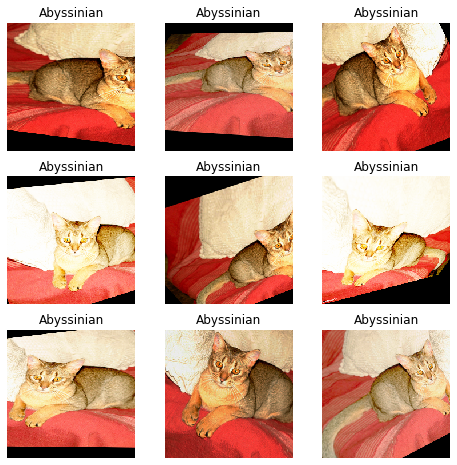

In [9]:
def _plot(i,j,ax):
    x,y = data.train_ds[3]
    x.show(ax, y=y)

plot_multi(_plot, 3, 3, figsize=(8,8))

In [10]:
data = get_data(224,bs)  # transform imgs' size to 3*224*224

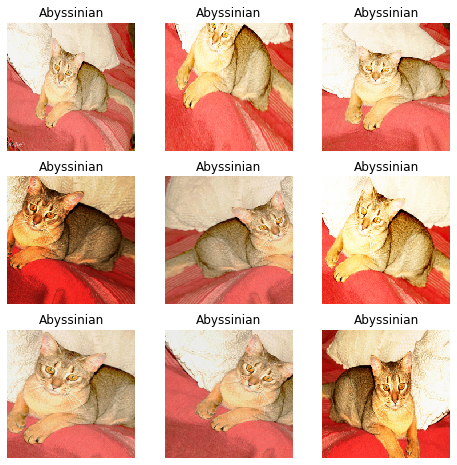

In [11]:
plot_multi(_plot, 3, 3, figsize=(8,8))

## Train a model

In [12]:
gc.collect()
learn = cnn_learner(data, models.resnet34, metrics=error_rate, bn_final=True)
# nf = num_features_model(nn.Sequential(*body.children())) * (2 if concat_pool else 1)
# nc = data.c
# lin_ftrs = [nf, 512, nc]
# if bn_final: layers.append(nn.BatchNorm1d(lin_ftrs[-1], momentum=0.01))

In [13]:
data.c

37

In [14]:
doc(callbacks.hooks.num_features_model)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


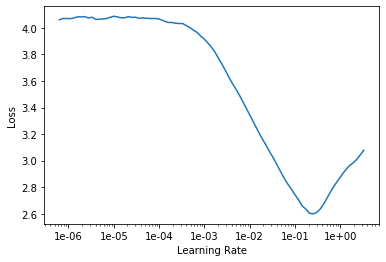

In [15]:
learn.lr_find()
learn.recorder.plot()

In [16]:
doc(learn.fit_one_cycle)

In [17]:
learn.fit_one_cycle(3, slice(1e-2), pct_start=0.8)

epoch,train_loss,valid_loss,error_rate,time
0,1.609275,0.373947,0.094046,00:15
1,0.967637,0.299156,0.087957,00:15
2,0.733584,0.243618,0.077131,00:15


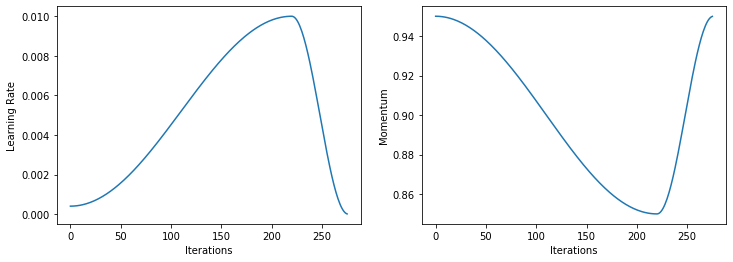

In [18]:
learn.recorder.plot_lr(show_moms=True)  # decreased when 3*92*0.8=220.8

In [20]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


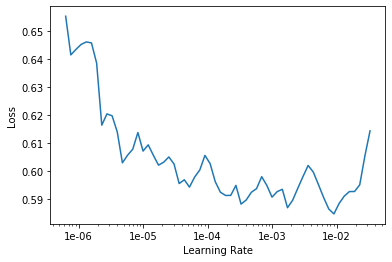

In [25]:
learn.recorder.plot(skip_end=30)

In [26]:
# The former training just trained the params of the last layer.
# Now we train all.
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-3), pct_start=0.8)

epoch,train_loss,valid_loss,error_rate,time
0,0.584104,0.241683,0.061570,00:20
1,0.547560,0.229476,0.062246,00:21


In [27]:
data = get_data(352,bs)  # change img's size to 3*352*352
learn.data = data

In [30]:
learn.lr_find()

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


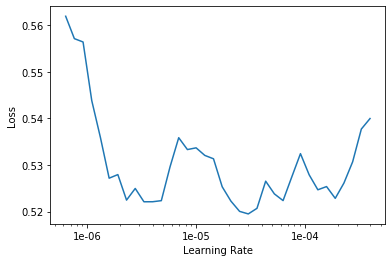

In [32]:
learn.recorder.plot(skip_end=25)

In [33]:
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.511747,0.213421,0.055480,00:45
1,0.483162,0.208502,0.055480,00:46


In [34]:
learn.save('352')

In [35]:
learn.load('352');

In [38]:
img = open_image(path/'Abyssinian_6.jpg')

In [39]:
learn.predict(img)

(Category Abyssinian,
 tensor(0),
 tensor([0.7651, 0.0609, 0.0017, 0.0065, 0.0128, 0.0188, 0.0025, 0.0018, 0.0024,
         0.0357, 0.0060, 0.0074, 0.0034, 0.0033, 0.0030, 0.0030, 0.0029, 0.0040,
         0.0020, 0.0033, 0.0027, 0.0040, 0.0052, 0.0021, 0.0018, 0.0049, 0.0045,
         0.0022, 0.0017, 0.0015, 0.0027, 0.0019, 0.0021, 0.0053, 0.0030, 0.0058,
         0.0020]))

In [41]:
path

PosixPath('/home/zcr/.fastai/data/oxford-iiit-pet/images')

## Convolution kernel

The details

In [42]:
data = get_data(352,bs=16)

In [43]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate, bn_final=True).load('352')

Category keeshond

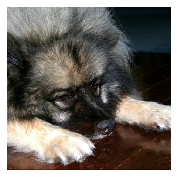

In [44]:
idx=0
x,y = data.valid_ds[idx]
x.show()
data.valid_ds.y[idx]

In [45]:
k = tensor([
    [0.  ,-5/3,1],
    [-5/3,-5/3,1],
    [1.  ,1   ,1],
]).expand(1,3,3,3)/6

In [46]:
k

tensor([[[[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]],

         [[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]],

         [[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]]]])

In [47]:
k.shape

torch.Size([1, 3, 3, 3])

In [48]:
t = data.valid_ds[0][0].data; t.shape

torch.Size([3, 352, 352])

In [49]:
t[None].shape

torch.Size([1, 3, 352, 352])

In [50]:
edge = F.conv2d(t[None], k)

In [51]:
edge.shape

torch.Size([1, 1, 350, 350])

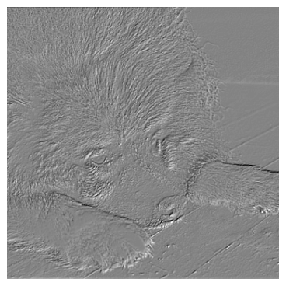

In [52]:
show_image(edge[0], figsize=(5,5));

In [53]:
data.c

37

In [54]:
(352+2*3-7)//2+1

176

In [107]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [108]:
print(learn.summary())

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 176, 176]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 176, 176]       128        True      
______________________________________________________________________
ReLU                 [64, 176, 176]       0          False     
______________________________________________________________________
MaxPool2d            [64, 88, 88]         0          False     
______________________________________________________________________
Conv2d               [64, 88, 88]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 88, 88]         128        True      
______________________________________________________________________
ReLU                 [64, 88, 88]         0          False     
___________________________________________________

## Heatmap

In [55]:
m = learn.model.eval();

In [56]:
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [57]:
from fastai.callbacks.hooks import *

In [58]:
m(xb).softmax(1)[0,24]

tensor(0.9581, device='cuda:0', grad_fn=<SelectBackward>)

In [59]:
def hooked_backward(cat=y):
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0,int(cat)].backward()
    return hook_a,hook_g

In [60]:
hook_a,hook_g = hooked_backward()

In [61]:
hook_a.stored[0][0]

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1053, 0.3077, 0.2205,
         0.1746, 0.0909],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.4850, 0.8756,
         0.3208, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.6258,
         0.4865, 0.2421],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1068, 0.7251,
         1.3100, 0.6725],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.6792,
         0.9404, 0.7457],
        [0.4815, 0.2413, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2055,
         0.2354, 0.2991],
        [2.1848, 1.4757, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.2093],
        [1.6871, 1.5596, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000],
        [1.3276, 2.1714, 1.0100, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0034],
        [0.2183, 0.0318, 0.0000, 0.00

In [62]:
hook_g.stored[0][0][0]

tensor([[-7.3417e-05, -7.3417e-05, -7.3417e-05, -7.3417e-05, -7.3417e-05,
         -7.3417e-05, -7.3417e-05, -7.3417e-05, -7.3417e-05, -7.3417e-05,
         -7.3417e-05],
        [-7.3417e-05, -7.3417e-05, -7.3417e-05, -7.3417e-05, -7.3417e-05,
         -7.3417e-05, -7.3417e-05, -7.3417e-05, -7.3417e-05, -7.3417e-05,
         -7.3417e-05],
        [-7.3417e-05, -7.3417e-05, -7.3417e-05, -7.3417e-05, -7.3417e-05,
         -7.3417e-05, -7.3417e-05, -7.3417e-05, -7.3417e-05, -7.3417e-05,
         -7.3417e-05],
        [-7.3417e-05, -7.3417e-05, -7.3417e-05, -7.3417e-05, -7.3417e-05,
         -7.3417e-05, -7.3417e-05, -7.3417e-05, -7.3417e-05, -7.3417e-05,
         -7.3417e-05],
        [-7.3417e-05, -7.3417e-05, -7.3417e-05, -7.3417e-05, -7.3417e-05,
         -7.3417e-05, -7.3417e-05, -7.3417e-05, -7.3417e-05, -7.3417e-05,
         -7.3417e-05],
        [-7.3417e-05, -7.3417e-05, -7.3417e-05, -7.3417e-05, -7.3417e-05,
         -7.3417e-05, -7.3417e-05, -7.3417e-05, -7.3417e-05, -7.3417e-0

In [63]:
acts = hook_a.stored[0].cpu()
acts.shape

torch.Size([512, 11, 11])

In [64]:
hook_g.stored[0].shape

torch.Size([1, 512, 11, 11])

In [65]:
2359296/(512*3*3)

512.0

In [66]:
avg_acts = acts.mean(0)
avg_acts.shape

torch.Size([11, 11])

In [67]:
def show_heatmap(hm):
    _,ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(hm, alpha=0.6, extent=(0,352,352,0),
              interpolation='bilinear', cmap='magma');

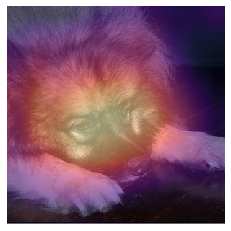

In [68]:
show_heatmap(avg_acts)

## Grad-CAM

Paper: [Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/abs/1610.02391)

In [69]:
grad = hook_g.stored[0][0].cpu()
grad_chan = grad.mean(1).mean(1)
grad.shape,grad_chan.shape

(torch.Size([512, 11, 11]), torch.Size([512]))

In [70]:
acts.shape, grad_chan[...,None,None].shape

(torch.Size([512, 11, 11]), torch.Size([512, 1, 1]))

In [71]:
(acts*grad_chan[...,None,None]).shape

torch.Size([512, 11, 11])

In [72]:
acts[0],grad_chan[0],(acts*grad_chan[...,None,None])[0]

(tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1053, 0.3077, 0.2205,
          0.1746, 0.0909],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.4850, 0.8756,
          0.3208, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.6258,
          0.4865, 0.2421],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1068, 0.7251,
          1.3100, 0.6725],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.6792,
          0.9404, 0.7457],
         [0.4815, 0.2413, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2055,
          0.2354, 0.2991],
         [2.1848, 1.4757, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.2093],
         [1.6871, 1.5596, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [1.3276, 2.1714, 1.0100, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0034],
         [0.2183, 0

In [73]:
0.1215 * 1.5413e-06

1.8726794999999998e-07

In [74]:
mult = (acts*grad_chan[...,None,None]).mean(0)

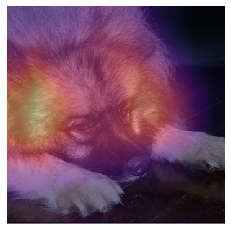

In [75]:
show_heatmap(mult)

In [76]:
fn = path/'../other/bulldog_maine.png' #Replace with your own image

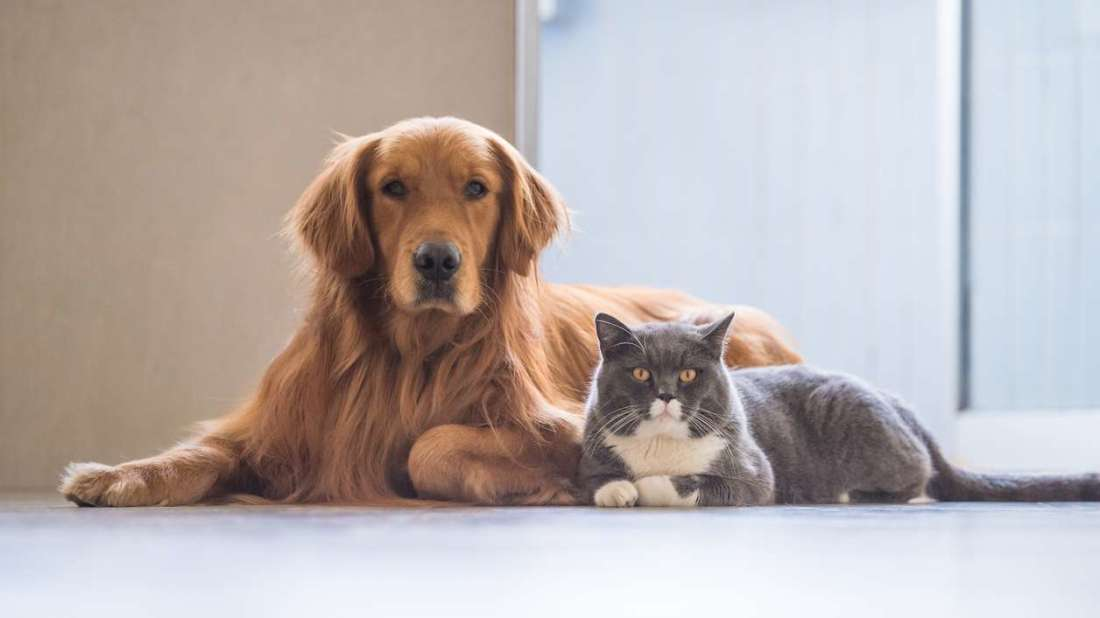

In [77]:
x = open_image(fn); x

In [78]:
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [79]:
m(xb).softmax(1)

tensor([[0.0178, 0.0165, 0.0138, 0.1129, 0.1543, 0.0092, 0.0849, 0.0410, 0.0263,
         0.0213, 0.0111, 0.0071, 0.0104, 0.0242, 0.0196, 0.0243, 0.0104, 0.0092,
         0.0269, 0.0150, 0.0174, 0.0547, 0.0094, 0.0077, 0.0081, 0.0354, 0.0211,
         0.0651, 0.0175, 0.0131, 0.0093, 0.0142, 0.0059, 0.0107, 0.0074, 0.0250,
         0.0221]], device='cuda:0', grad_fn=<SoftmaxBackward>)

In [80]:
hook_a,hook_g = hooked_backward()

In [81]:
acts = hook_a.stored[0].cpu()
grad = hook_g.stored[0][0].cpu()

grad_chan = grad.mean(1).mean(1)
mult = (acts*grad_chan[...,None,None]).mean(0)

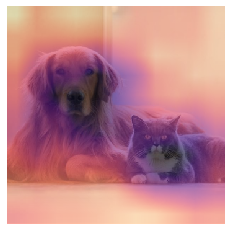

In [82]:
show_heatmap(mult)

In [83]:
data.classes[0]

'Abyssinian'

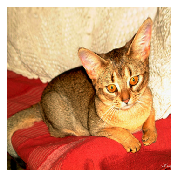

In [84]:
data.train_ds[3][0].show()

In [85]:
hook_a,hook_g = hooked_backward(0)

In [86]:
acts = hook_a.stored[0].cpu()
grad = hook_g.stored[0][0].cpu()

grad_chan = grad.mean(1).mean(1)
mult = (acts*grad_chan[...,None,None]).mean(0)

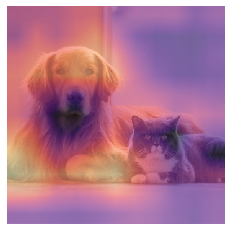

In [87]:
show_heatmap(mult)

## fin